In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import plotly.express as px

In [106]:
!pip install plotly

^C


In [2]:
ads = pd.read_csv('ads_data.csv', parse_dates = ['date', 'time'])
clients = pd.read_csv('ads_clients_data.csv', parse_dates = ['date', 'create_date'])


In [3]:
clients.dtypes

date               datetime64[ns]
client_union_id             int64
community_id                int64
create_date        datetime64[ns]
dtype: object

In [4]:
ads.dtypes

date                     datetime64[ns]
time                     datetime64[ns]
event                            object
platform                         object
ad_id                             int64
client_union_id                   int64
campaign_union_id                 int64
ad_cost_type                     object
ad_cost                         float64
has_video                         int64
target_audience_count             int64
dtype: object

In [5]:
ads.shape

(1000000, 11)

In [6]:
ads.time = ads.time.apply(lambda x: x.time())


In [7]:
ads.head(5)

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [8]:
ads.ad_cost_type.unique()

array(['CPM', 'CPC'], dtype=object)

CPM - плата за 1000 показов


CPC - плата за клик

In [9]:
clicks_and_views = ads.groupby(['ad_id', 'event'], as_index=False)\
    .agg({'ad_cost_type' : 'count'})\
    .rename(columns= {'ad_cost_type' : 'amount'})

In [10]:
pivot_clicks_views = clicks_and_views.pivot(index= 'ad_id', columns='event', values= 'amount')

In [11]:
pivot_clicks_views.loc[pivot_clicks_views.view.isna(), :]

event,click,view
ad_id,,
19223,7.0,NaN
26204,6.0,NaN
41500,20.0,NaN
45418,3.0,NaN
115825,4.0,NaN
117364,7.0,NaN
120431,35.0,NaN
120536,6.0,NaN
120796,1.0,NaN


Нашли объявления с багами, такие у которых есть клики при отсутствии просмотров.
Заполним пропуски медианным значением, так как присутствуют выбросы

In [12]:
pivot_clicks_views.loc[pivot_clicks_views.view.isna(), :] = pivot_clicks_views.loc[pivot_clicks_views.view.isna(), :]\
    .fillna(round(pivot_clicks_views.view.median()))

In [13]:
pivot_clicks_views.loc[pivot_clicks_views.view.isna(), :]

event,click,view
ad_id,,


In [14]:
click_mean = pivot_clicks_views.click.fillna(0).mean()

In [15]:
view_mean = pivot_clicks_views.view.mean()

In [16]:
print(f'Среднее кол-во кликов: {round(click_mean)}\nСреднее кол-во просмотров: {round(view_mean)}')

Среднее кол-во кликов: 113
Среднее кол-во просмотров: 924


In [17]:
views_distribution = clicks_and_views.query('event == "view"'); views_distribution

,ad_id,event,amount
1,2,view,101
3,3,view,184
5,1902,view,41
6,2064,view,35
8,2132,view,58
...,...,...,...
1475,122004,view,100
1476,122013,view,156
1477,122023,view,68
1479,122031,view,138


In [18]:
count_of_amounts = views_distribution.amount\
    .apply(lambda x: (views_distribution.loc[:, 'amount'] == x).sum())


In [19]:
distrib = pd.DataFrame(data = {'amount' : views_distribution.amount.reset_index(drop = True),
                                       'number' : count_of_amounts.reset_index(drop = True)})

In [20]:
distrib = distrib.drop_duplicates(subset='amount').reset_index(drop = True)

In [21]:
(views_distribution.ad_id.isin(ads.ad_id.unique()) == False).sum()

0

In [22]:
distrib


,amount,number
0,101,5
1,184,3
2,41,11
3,35,9
4,58,11
...,...,...
377,390,1
378,583,1
379,891,1
380,574,1


Так как разброс значений amount слишком велик - прологарифмируем их

In [23]:
distrib.amount = np.log(distrib.amount); 

D:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='amount', ylabel='Density'>

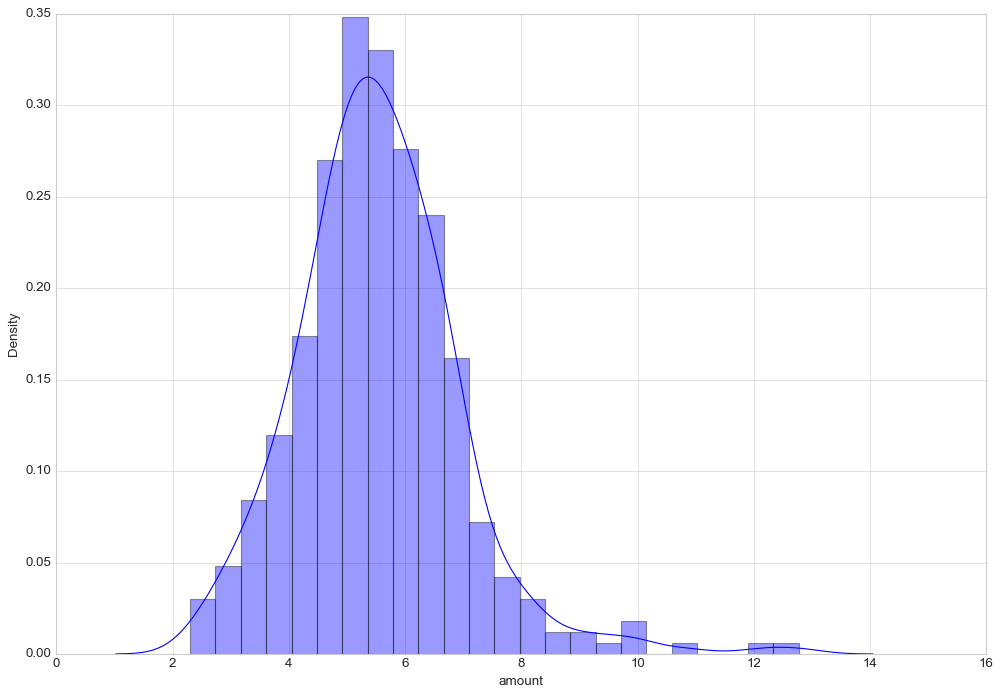

In [102]:
plt.style.use('seaborn-whitegrid')
plt.subplots(figsize = (15, 10))
sns.distplot(distrib.amount)

In [28]:
ads

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501
...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-04-05,20:59:52,view,web,112583,111818,112260,CPM,210.1,0,22392
999996,2019-04-05,20:59:52,view,android,112583,111818,112260,CPM,210.1,0,22392
999997,2019-04-05,20:59:52,click,web,112583,111818,112260,CPM,210.1,0,22392
999998,2019-04-05,20:59:52,view,web,113350,113036,113251,CPM,183.3,0,571929


In [29]:
view_by_date = ads.query('event == "view"')\
                .pivot_table(index = 'ad_id',
               columns = 'date',
               values = 'time',
               aggfunc= 'count')

In [30]:
view_by_date

date,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06
ad_id,,,,,,
2,83.0,18.0,NaN,NaN,NaN,NaN
3,158.0,26.0,NaN,NaN,NaN,NaN
1902,NaN,NaN,34.0,7.0,NaN,NaN
2064,NaN,28.0,7.0,NaN,NaN,NaN
2132,NaN,NaN,25.0,27.0,6.0,NaN
...,...,...,...,...,...,...
122004,85.0,15.0,NaN,NaN,NaN,NaN
122013,NaN,NaN,NaN,134.0,22.0,NaN
122023,NaN,NaN,NaN,53.0,15.0,NaN


In [31]:
mean_views = view_by_date.mean()

In [32]:
rolling_views = mean_views.rolling(2).mean()

<AxesSubplot:xlabel='date'>

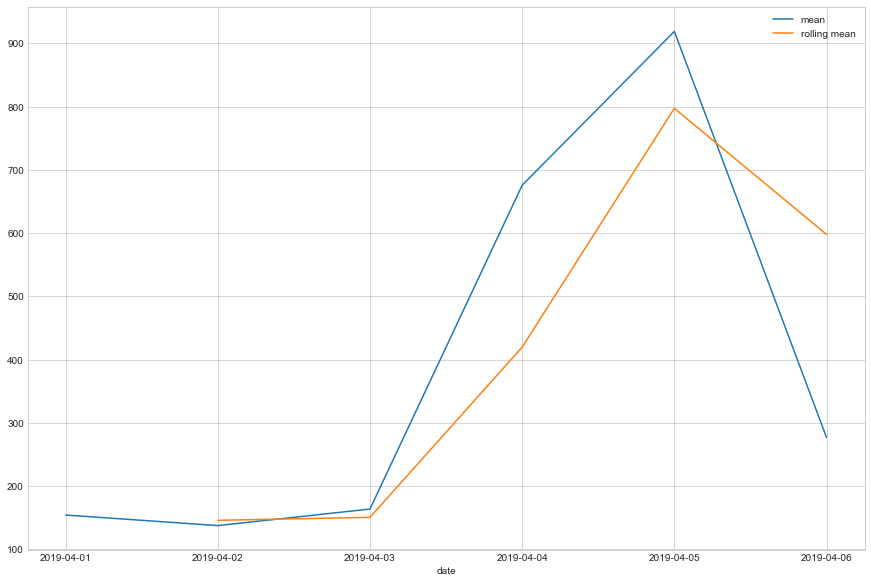

In [33]:
fig, ax = plt.subplots(figsize = (15,10))

sns.lineplot(data = mean_views, ax= ax, label = 'mean')
sns.lineplot(data = rolling_views, ax=ax, label = 'rolling mean')
#ax.legend(prop=dict(size=20))

In [34]:
problem_day = (mean_views - rolling_views).abs()\
    .idxmax()

In [35]:
prob_index = view_by_date.loc[:,problem_day.strftime('%Y-%m-%d')]\
    .fillna(0)\
    .sort_values()\
    .tail(1)\
    .index[0];
prob_index

112583

Проблемное объявление - объявление с id 112583

In [36]:
clients.date.value_counts()

2020-05-07    122078
Name: date, dtype: int64

In [37]:
clients = clients.drop(columns = 'date')

In [38]:
df_to_analyze = ads.merge(clients, on = 'client_union_id')\
    .loc[:, ['date', 'time', 'create_date', 'ad_id', 'client_union_id']]

In [39]:
df_to_analyze

,date,time,create_date,ad_id,client_union_id
0,2019-04-01,00:00:48,2018-12-04,45061,34734
1,2019-04-01,00:03:28,2018-12-04,45061,34734
2,2019-04-01,00:04:58,2018-12-04,45061,34734
3,2019-04-01,00:10:23,2018-12-04,45061,34734
4,2019-04-01,00:15:42,2018-12-04,45061,34734
...,...,...,...,...,...
999995,2019-04-04,18:07:25,2019-03-04,43921,30712
999996,2019-04-04,18:29:06,2019-03-04,43921,30712
999997,2019-04-04,18:55:46,2019-03-04,43921,30712
999998,2019-04-04,19:21:09,2019-03-04,43921,30712


In [40]:
first_ad_date = df_to_analyze.groupby(['client_union_id'])\
    .agg({'date' : 'min'})

In [41]:
first_ad_date = first_ad_date.merge(clients, on = 'client_union_id')

In [42]:
first_ad_date.create_date = pd.to_datetime(first_ad_date.create_date)
first_ad_date['delta'] = first_ad_date.date - first_ad_date.create_date

In [43]:
first_ad_date.delta.mean().days

124

Конверсия = кол-во клиентов, которые размещали рекламу / кол-во все клиентов

In [66]:
conversion = first_ad_date.shape[0] / clients.client_union_id.nunique() 

In [68]:
print(f'Конверсия = {conversion:.3%}')

Конверсия = 0.686%


In [74]:
first_ad_date.delta =pd.cut(first_ad_date.delta, 
                            bins =pd.to_timedelta([0, 30, 90, 180, 365], unit = 'd'),\
                            labels = ['0-30 days','30-90 days', '90-180 days', '90-365 days'])

In [75]:
first_ad_date

,client_union_id,date,community_id,create_date,delta
0,1,2019-04-01,-130371893,2018-12-24,90-180 days
1,9,2019-04-03,-130215524,2018-12-10,90-180 days
2,13,2019-04-02,-130623793,2019-01-26,30-90 days
3,16,2019-04-03,-130748007,2018-12-19,90-180 days
4,20,2019-04-02,-130189700,2019-03-01,30-90 days
...,...,...,...,...,...
833,122004,2019-04-01,-130906608,2019-01-24,30-90 days
834,122013,2019-04-04,-130032486,2018-11-04,90-180 days
835,122023,2019-04-04,-130823359,2018-11-29,90-180 days
836,122031,2019-04-05,-130605132,2018-12-30,90-180 days


In [110]:
px.bar(first_ad_date.delta.value_counts())